In [1]:
import os
import pandas as pd
#import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import time
from testWN import testWN as twm
import wntr
import wntr.network.controls as controls
import wntr.metrics.economic as metrics
import pdb
import pickle

In [2]:
%matplotlib notebook

# Water Network data loading

/Applications/anaconda3/lib/python3.7/site-packages/wntr/epanet/io.py:2085: UserWarning: Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


<IPython.core.display.Javascript object>


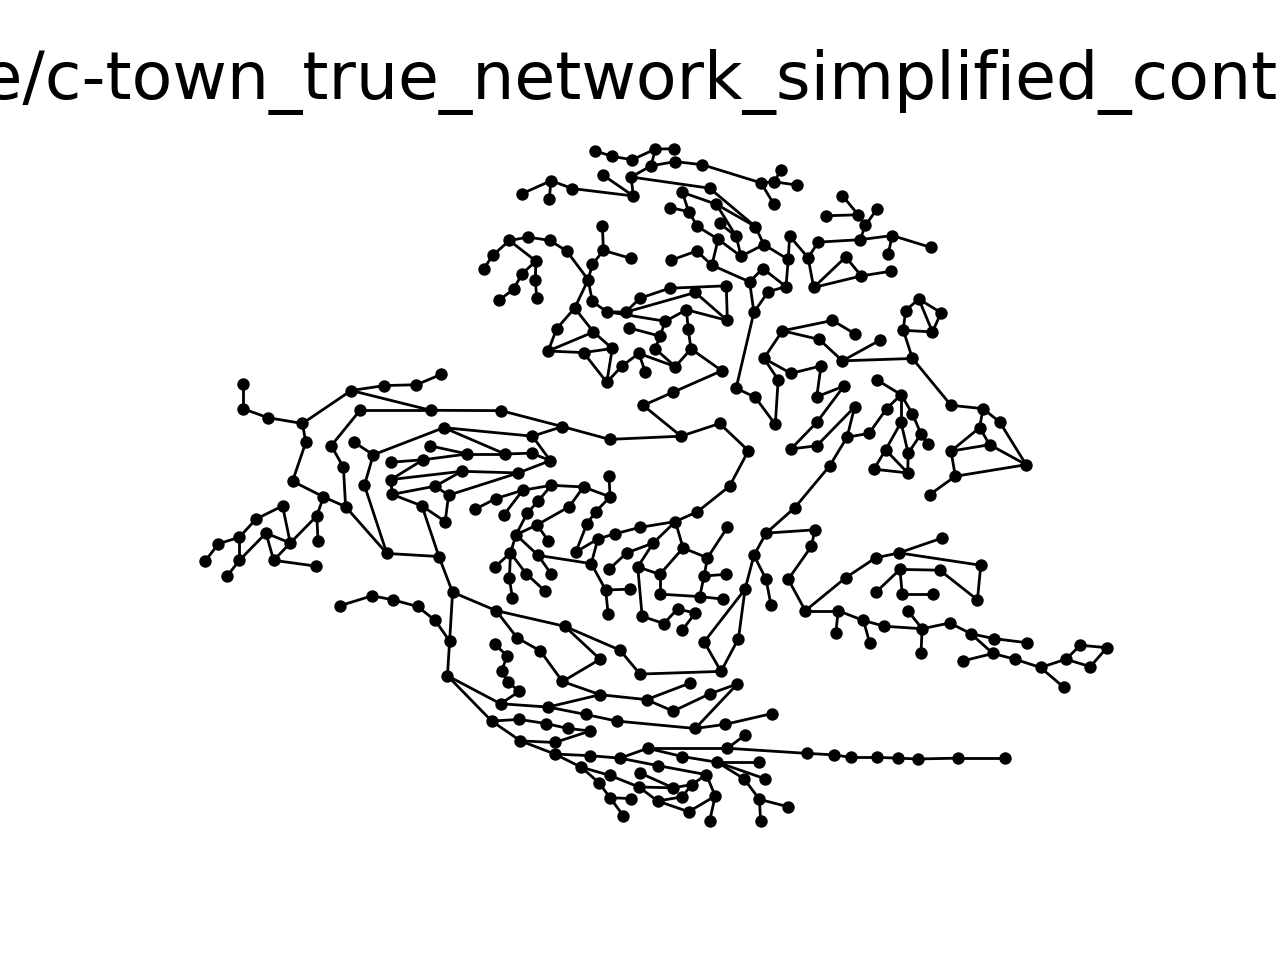

/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [6]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'

ctown = twm(inp_file)

# plt.figure()

# %%
# Graphical representation of the network
plt.rcParams.update({'font.size': 20})
wntr.graphics.plot_network(ctown.wn, title=ctown.wn.name, node_labels=False, link_labels=False, directed=False)
fig = mpl.pyplot.gcf()
mpl.rcParams.update(mpl.rcParamsDefault)

plt.show()

# Modify demand patterns

<IPython.core.display.Javascript object>


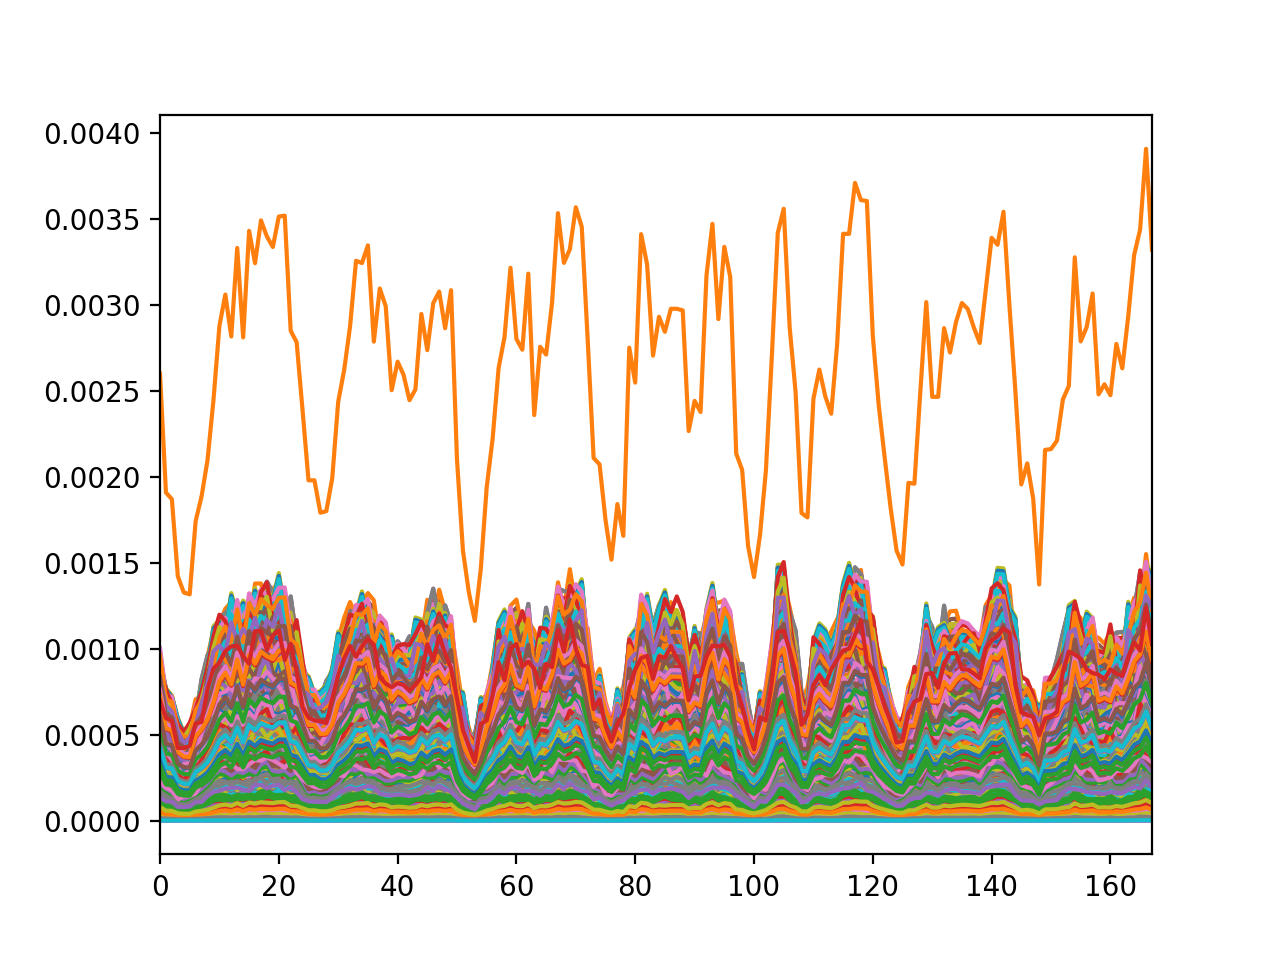

In [7]:
# Get and display demand patterns
df_pat = pd.DataFrame(columns = ctown.wn.junction_name_list)
for name, j in ctown.wn.junctions():
   base = j.demand_timeseries_list[0].base_value
   pat = j.demand_timeseries_list[0].pattern
   if pat is not None:
       df_pat.loc[:,name] = base * j.demand_timeseries_list[0].pattern.multipliers

#get nodes with base-demand > 0
d_juncs = df_pat.dropna(axis=1).columns

#display demand patterns
df_pat.plot(legend=None)
plt.show()

In [9]:
# Varying demand patterns
# Scaling
ctown.randomlyScaleMultipliers(0.1)  # Input is the maximum possible percentage of change for each pattern value

# Shifting
ctown.randomlyShiftMultipliers(3)  # Input is the maximum time shift allowed (in hours)

# ::::: SAVE seed

<IPython.core.display.Javascript object>


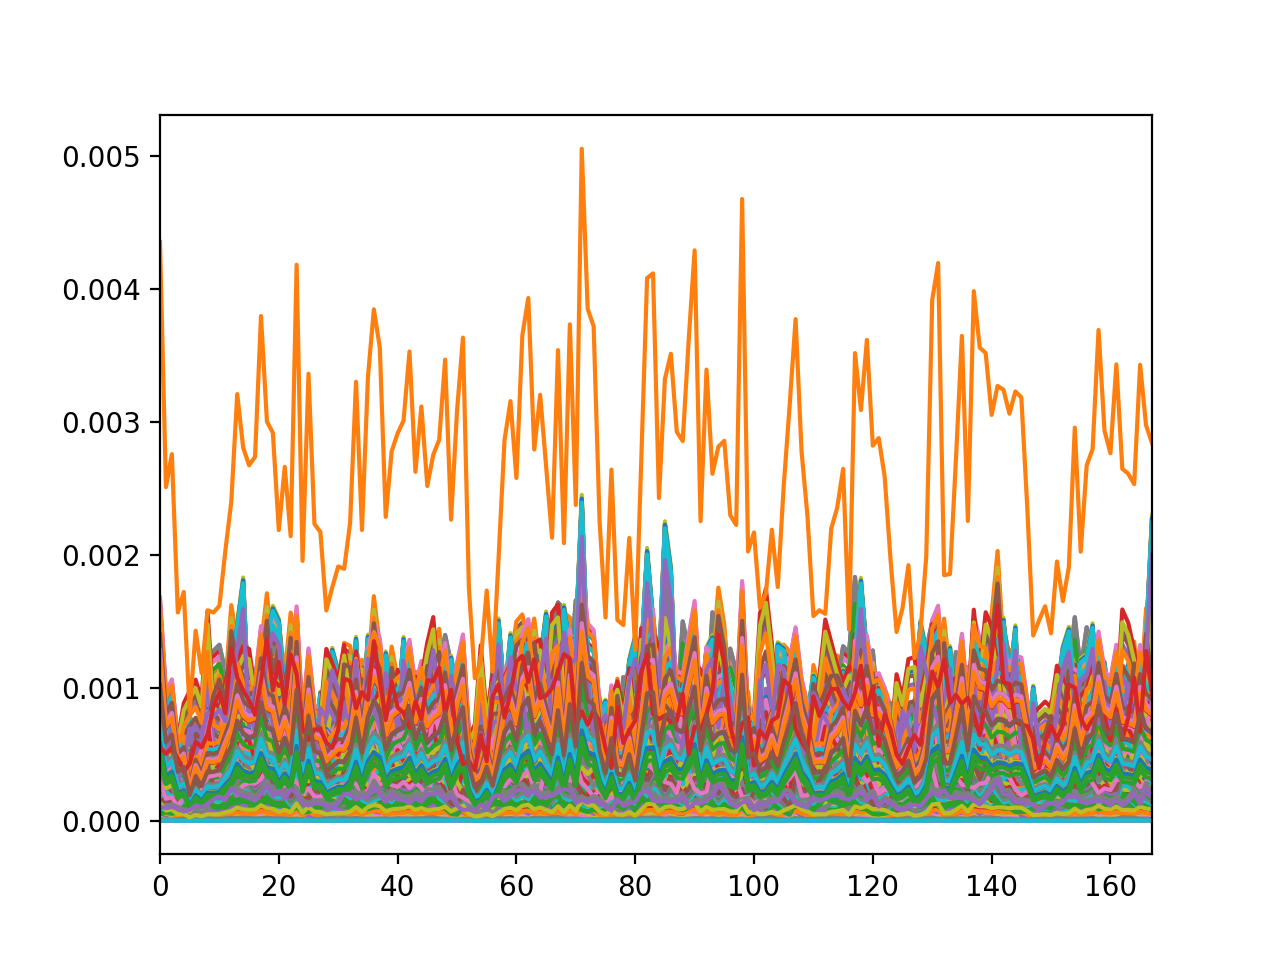

In [10]:
# Representing modified demand patterns
df_pat = pd.DataFrame(columns = ctown.wn.junction_name_list)
for name, j in ctown.wn.junctions():
   base = j.demand_timeseries_list[0].base_value
   pat = j.demand_timeseries_list[0].pattern
   if pat is not None:
       df_pat.loc[:,name] = base * j.demand_timeseries_list[0].pattern.multipliers

# get nodes with base-demand > 0
d_juncs = df_pat.dropna(axis=1).columns

# display demand patterns
df_pat.plot(legend=None)
plt.show()

# Run simulation

In [11]:
nDaysSim = 7
nHoursSim = 24*nDaysSim

# wn.options.time.duration = 3600*24*nDaysSim#*nYearsSim
ctown.wn.options.time.hydraulic_timestep = 60*15  # 15 min
ctown.wn.options.time.quality_timestep = 60*15  # 5 min
ctown.wn.options.quality.mode = 'AGE'
ctown.wn.options.results.energystr = True

start_time = time.time()

# TODO: Add controls
#ctown.addControls('V45', 'setting', 10., 'T4', '<', 3, 'user_added_1')
#ctown.addControls('V45', 'setting', 40., 'T4', '>', 4, 'user_added_2')


# ::: Adding controls
control_components = ctown.wn.pump_name_list + ctown.wn.valve_name_list
control_vector = np.array([ 1., 1., 1., 1., 1., 40., 40., 40., 0.])
# Add controls random and then 
min_control = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.]) # Lower bondary for contrrols
max_control = np.array([2., 2., 2., 2., 2., 60.0, 60.0, 60.0, 5. ]) # Upper bondary for contrrols

control_vector_constraints = np.maximum(min_control, np.minimum(control_vector, max_control))

# ::: Running the simulation
start_time = time.time()

for i in range(nHoursSim):
    # Add controls
    for j in range(len(control_components)):
        currComp = ctown.wn.get_link(control_components[j])
        
        cond = controls.SimTimeCondition(ctown.wn, None,i*3600)
        act = controls.ControlAction(currComp, 'setting', control_vector_constraints[j])
        ctrl = controls.Control(cond,act, name=control_components[j])
        if np.isin(control_components[j], ctown.wn.control_name_list):
            ctown.wn.remove_control(control_components[j])
        ctown.wn.add_control(control_components[j], ctrl)
        ctown.wn.get_control(control_components[j])

    # Run the simulation for the next time step
    ctown.wn.options.time.duration = 3600*i
    sim = wntr.sim.EpanetSimulator(ctown.wn)
    results = sim.run_sim()

print('Total simulation time: %.3f s' % (time.time()-start_time))
with open("results_sim.pkl", "wb") as f:
    pickle.dump(results, f)

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(10, 8))

Total simulation time: 44.152 s


In [ ]:
# CHeck that setting is stored in the results